## Machine Learning Beginner Guide - Topics

- Data Analysis
- Data Scaling
- Data Modeling
- Hyper-parameter Tuning.
- Cross Validation
- Predictions

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import sklearn
#sklearn.metrics.SCORERS.keys()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
print(data.shape)
data.tail()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [6]:
X = data.iloc[:,:-1] # Independent variables
y = data['Outcome'] # Dependent Variables

## Data Analysis

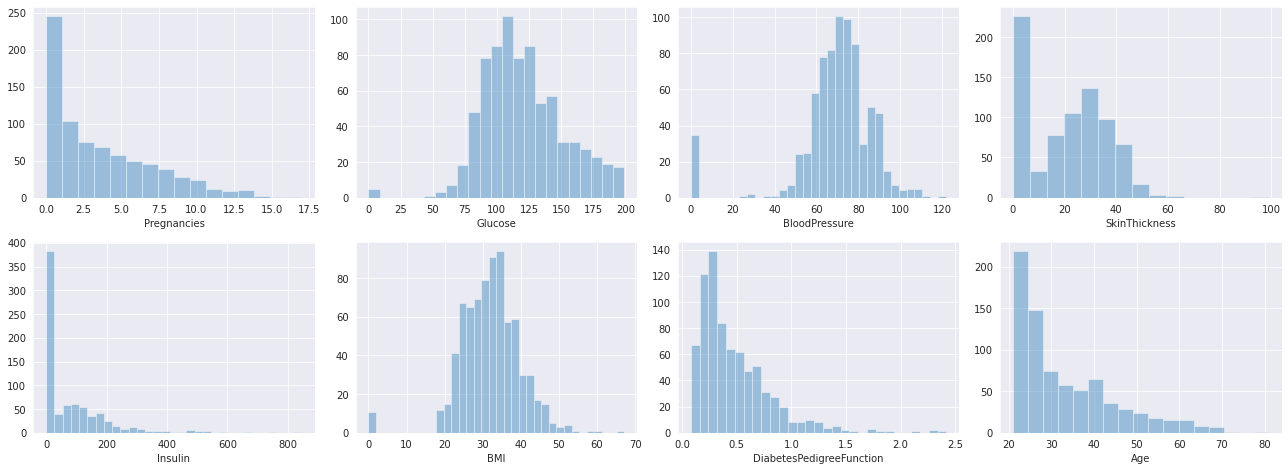

In [7]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(X):
    plt.subplot(5,4,index+1)
    sns.distplot(X.loc[:,col],kde= False)
fig.tight_layout(pad=1.0)

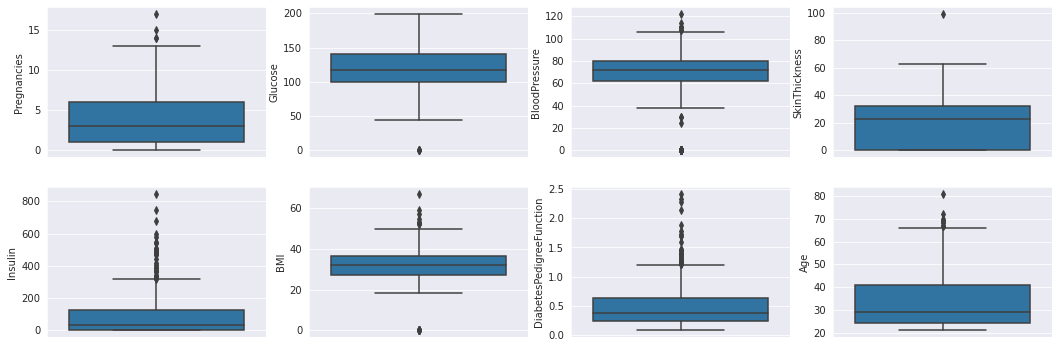

In [8]:
plt.figure(figsize=(18,16))
for index,col in enumerate(X):
    plt.subplot(5,4,index+1)
    sns.boxplot(y = col, data= X)
fig.tight_layout(pad=1.0)

### Removing outliers from the Independent variables

In [9]:
data = data.drop(data[data['Pregnancies']>11].index)
data = data.drop(data[data['Glucose']<30].index)
data = data.drop(data[data['BloodPressure']>110].index)
data = data.drop(data[data['BloodPressure']<20].index)
data = data.drop(data[data['SkinThickness']>80].index)
data = data.drop(data[data['BMI']>55].index)
data = data.drop(data[data['BMI']<10].index)
data = data.drop(data[data['DiabetesPedigreeFunction']>1.6].index)
data = data.drop(data[data['Insulin']>400].index)
data = data.drop(data[data['Age']>80].index)

In [10]:
data.shape

(671, 9)

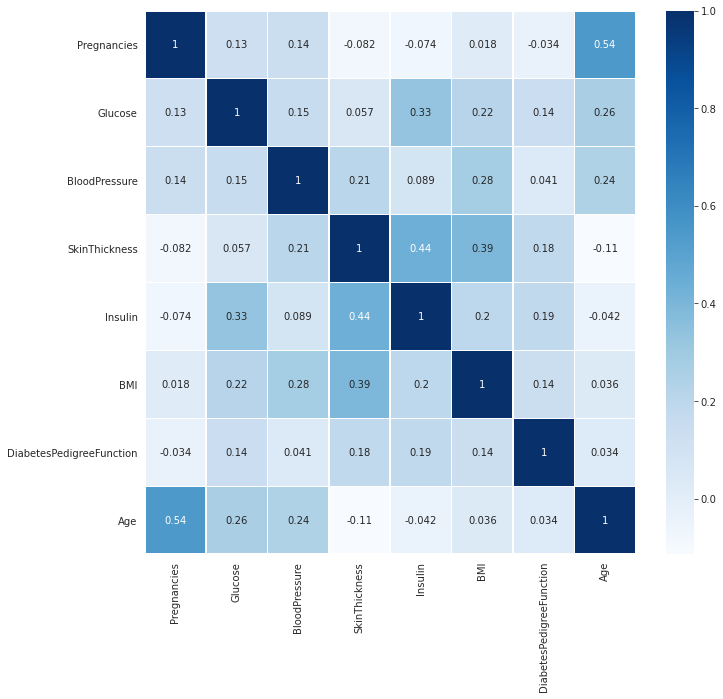

In [11]:
plt.figure(figsize=(11,10))
correlation = X.corr()
sns.heatmap(correlation,linewidth = 0.7,cmap = 'Blues',annot = True)


In [12]:
X = X.loc[data.index]
y = y.loc[data.index]

## Data Scaling

from sklearn.preprocessing import RobustScaler
cols = X.columns
transformer = RobustScaler().fit(X[cols])
X[cols] = transformer.transform(X[cols])

### Note it is not necessary to Scale the data for boosting method

## Data Modeling

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.25,random_state = 100)

In [14]:
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,f1_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
xgb = XGBClassifier(booster ='gbtree',objective ='binary:logistic')

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5,0.4],
    'n_estimators' : [100, 500, 1000,1500,2000],
    'max_depth' : [2,3,5, 6,8, 9],
    'min_child_weight' : [1, 5, 10],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1],
    'colsample_bytree' : [0.3,0.4,0.5,0.7],
    'gamma' : [0.0,0.1,0.2,0.3,0.4]
}

xgb_tuning = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst ,
                          n_iter = 5,
                        cv =6)
       
xgb_search = xgb_tuning.fit(X_train,y_train,
                           early_stopping_rounds = 5,
                           eval_set=[(X_val,y_val)],
                           verbose = False)

##hyperparameter tuning

best_param = xgb_search.best_params_
xgb = XGBClassifier(**best_param)
print(best_param)

{'reg_lambda': 0.1, 'reg_alpha': 0.001, 'n_estimators': 2000, 'min_child_weight': 10, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.7}


In [20]:
xgb_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.001, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
y_pred = xgb_search.predict(X_val)
score0 = accuracy_score(y_pred,y_val)
#print(round(score0*100,4))
print('Score: {}%'.format(round(score0*100,4)))

Score: 80.3571%


In [22]:
acc_scores1_xgb =  cross_val_score(xgb_search,X,y,n_jobs=5,
                                 cv = StratifiedKFold(n_splits=10),
                                 scoring = 'accuracy')
acc_scores1_xgb

array([0.69117647, 0.7761194 , 0.73134328, 0.76119403, 0.73134328,
       0.73134328, 0.79104478, 0.73134328, 0.76119403, 0.8358209 ])

In [23]:
print(acc_scores1_xgb.mean())

0.7541922739244951


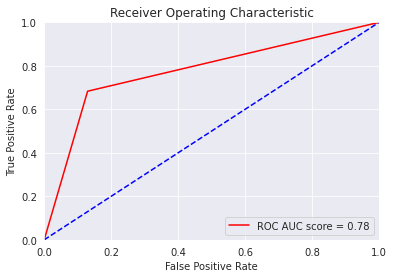

In [24]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Using Cross Validation with Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()
lr.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [26]:
log_scores_logi = -1 * cross_val_score(lr, X, y,
                              cv=5,
                              scoring='neg_log_loss')
acc_scores1_logi =  cross_val_score(lr,X,y,
                                 cv = 5,
                                 scoring = 'accuracy')
f_score_logi =  cross_val_score(lr,X,y,
                                 cv = 5,
                                 scoring = 'f1')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [27]:
print("log_loss scores:\n", log_scores_logi)
print("Accuracy scores:\n", acc_scores1_logi)
print("f1_score scores:\n", f_score_logi)

log_loss scores:
 [0.53186655 0.49132521 0.5380563  0.43570244 0.44921339]
Accuracy scores:
 [0.76296296 0.76119403 0.73880597 0.82835821 0.78358209]
f1_score scores:
 [0.56756757 0.61904762 0.55696203 0.70886076 0.61333333]


In [28]:
print(acc_scores1_logi.mean())

0.7749806522940851


### If you do like my work and found some useful insights from it, please Upvote and comment your thoughts below. 


- Some References I took from:
 - [Tuning](https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning)
 - [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
 - [XGBClassifier](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)